# Interacting with CLIP

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [1]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to c:\users\d4\appdata\local\temp\pip-req-build-7cvvq5_z
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\d4\AppData\Local\Temp\pip-req-build-7cvvq5_z'


In [2]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)


Torch version: 2.7.0+cu118


C:\Users\d4\AppData\Local\Temp\ipykernel_36576\189856270.py:3: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import packaging


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [3]:
import clip
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [4]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [24]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x000001C17841AA60>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [42]:
clip.tokenize("Hello World !!!")

tensor([[49406,  3306,  1002,   995, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [56]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse", 
    "coffee": "a cup of coffee on a saucer"
}

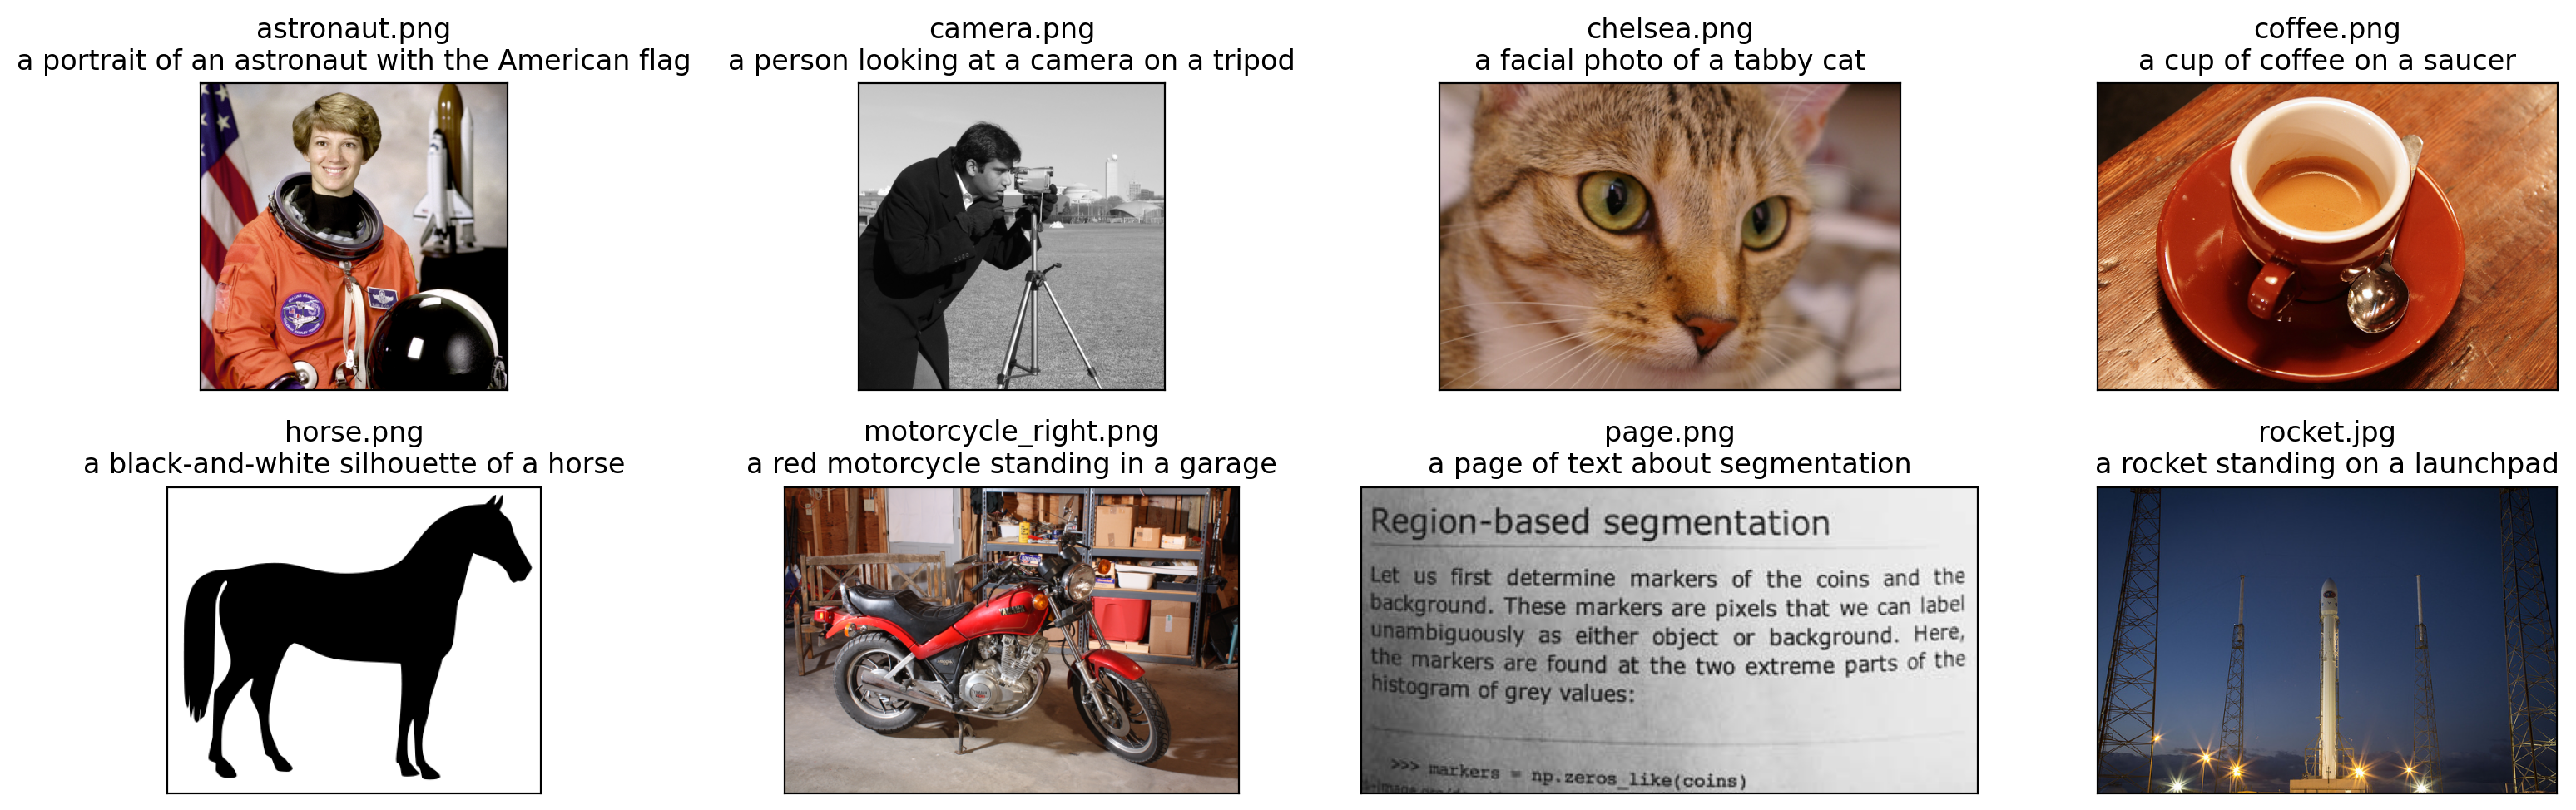

In [57]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")
  
    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()


## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [58]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

In [59]:
print(image_input)

tensor([[[[ 0.2953, -0.3616,  0.1931,  ...,  0.0471,  0.0471,  0.0179],
          [ 1.2588,  1.0252,  1.1420,  ...,  0.0617,  0.0325,  0.0471],
          [ 1.6530,  1.5362,  1.3172,  ...,  0.0471,  0.0471,  0.0325],
          ...,
          [ 0.9230,  0.9522,  0.8501,  ..., -0.6828, -0.9018, -1.7923],
          [ 0.9230,  0.8792,  0.6749,  ..., -0.6390, -1.6755, -1.7923],
          [ 0.8938,  0.7771,  0.4997,  ..., -0.8434, -1.2667, -1.7923]],

         [[ 0.3190, -0.2963,  0.2589,  ...,  0.0338,  0.0338,  0.0038],
          [ 1.2945,  1.0694,  1.2044,  ...,  0.0038,  0.0038,  0.0038],
          [ 1.6697,  1.5796,  1.3395,  ...,  0.0188,  0.0188,  0.0038],
          ...,
          [ 0.7692,  0.8292,  0.6792,  ..., -0.7466, -0.8816, -1.7521],
          [ 0.7842,  0.7392,  0.5141,  ..., -0.6715, -1.6470, -1.7521],
          [ 0.7692,  0.6191,  0.3190,  ..., -0.8516, -1.2118, -1.7521]],

         [[ 0.5959,  0.1977,  0.4253,  ...,  0.1124,  0.1124,  0.0698],
          [ 1.3638,  1.1789,  

In [47]:
print(text_tokens)

tensor([[49406,   589,   533,   320,  5352,   539,   550, 18376,   593,   518,
          2151,  4859, 49407,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [49406,   589,   533,   320,  2533,  1312,   536,   320,  3934,   525,
           320, 36141, 49407,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0, 

In [48]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

In [49]:
print(image_features)

tensor([[ 0.3174,  0.3047, -0.1548,  ..., -0.1083, -0.2205,  0.1323],
        [-0.0021, -0.0923,  0.0243,  ...,  0.2363, -0.2756,  0.2861],
        [-0.2812, -0.2070,  0.0352,  ...,  1.1123, -0.2534, -0.1090],
        ...,
        [ 0.4048,  0.4490, -0.0290,  ...,  0.7642, -0.0147,  0.4526],
        [ 0.4106,  0.4067, -0.1129,  ...,  0.6787,  0.3213,  0.1973],
        [ 0.0748,  0.2103,  0.0690,  ...,  0.0157, -0.2119, -0.5752]],
       device='cuda:0')


In [50]:
print(text_features)

tensor([[-0.1665,  0.0521, -0.1534,  ...,  0.3125, -0.1361, -0.2659],
        [ 0.0590, -0.0759, -0.3892,  ..., -0.3208, -0.1188, -0.1010],
        [-0.0395, -0.0321, -0.0906,  ...,  0.2249, -0.3804, -0.4331],
        ...,
        [ 0.3804,  0.1037,  0.3396,  ...,  0.4021, -0.0573, -0.0110],
        [-0.0848,  0.3237,  0.0922,  ...,  0.2371,  0.3000,  0.4392],
        [ 0.0687,  0.1185, -0.0770,  ...,  0.1405, -0.0837, -0.2223]],
       device='cuda:0')


## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

In [60]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

In [61]:
print(image_features)

tensor([[ 0.0343,  0.0329, -0.0167,  ..., -0.0117, -0.0238,  0.0143],
        [-0.0002, -0.0082,  0.0022,  ...,  0.0211, -0.0246,  0.0256],
        [-0.0246, -0.0181,  0.0031,  ...,  0.0973, -0.0222, -0.0095],
        ...,
        [ 0.0388,  0.0431, -0.0028,  ...,  0.0733, -0.0014,  0.0434],
        [ 0.0470,  0.0466, -0.0129,  ...,  0.0778,  0.0368,  0.0226],
        [ 0.0070,  0.0196,  0.0064,  ...,  0.0015, -0.0198, -0.0537]],
       device='cuda:0')


In [62]:
print(text_features)

tensor([[-0.0194,  0.0061, -0.0179,  ...,  0.0364, -0.0159, -0.0310],
        [ 0.0062, -0.0080, -0.0412,  ..., -0.0339, -0.0126, -0.0107],
        [-0.0048, -0.0039, -0.0110,  ...,  0.0274, -0.0464, -0.0528],
        ...,
        [ 0.0467,  0.0127,  0.0417,  ...,  0.0493, -0.0070, -0.0013],
        [-0.0079,  0.0301,  0.0086,  ...,  0.0220,  0.0279,  0.0408],
        [ 0.0077,  0.0132, -0.0086,  ...,  0.0157, -0.0093, -0.0248]],
       device='cuda:0')


In [63]:
print(similarity)

[[0.2767535  0.16569099 0.1681848  0.14944148 0.16268669 0.15013744
  0.12996897 0.22063881]
 [0.18589723 0.3047522  0.20824242 0.13664052 0.195153   0.16070037
  0.1886107  0.20686054]
 [0.1195526  0.15943852 0.30733213 0.16592361 0.15266503 0.12493186
  0.12085815 0.11865789]
 [0.14816979 0.17415056 0.18379742 0.2931285  0.15404154 0.12159226
  0.14360872 0.12260559]
 [0.11475785 0.21307051 0.14575116 0.15418771 0.3460052  0.16744125
  0.1725231  0.1486975 ]
 [0.1548412  0.11979297 0.15413451 0.12522976 0.16233622 0.3205658
  0.1426791  0.15934251]
 [0.14681202 0.20142311 0.20114648 0.1982943  0.20010363 0.16317923
  0.35386756 0.1595423 ]
 [0.19196835 0.20163739 0.17764056 0.13834564 0.17000198 0.15824685
  0.17428675 0.3028894 ]]


Text(0.5, 1.0, 'Cosine similarity between text and image features')

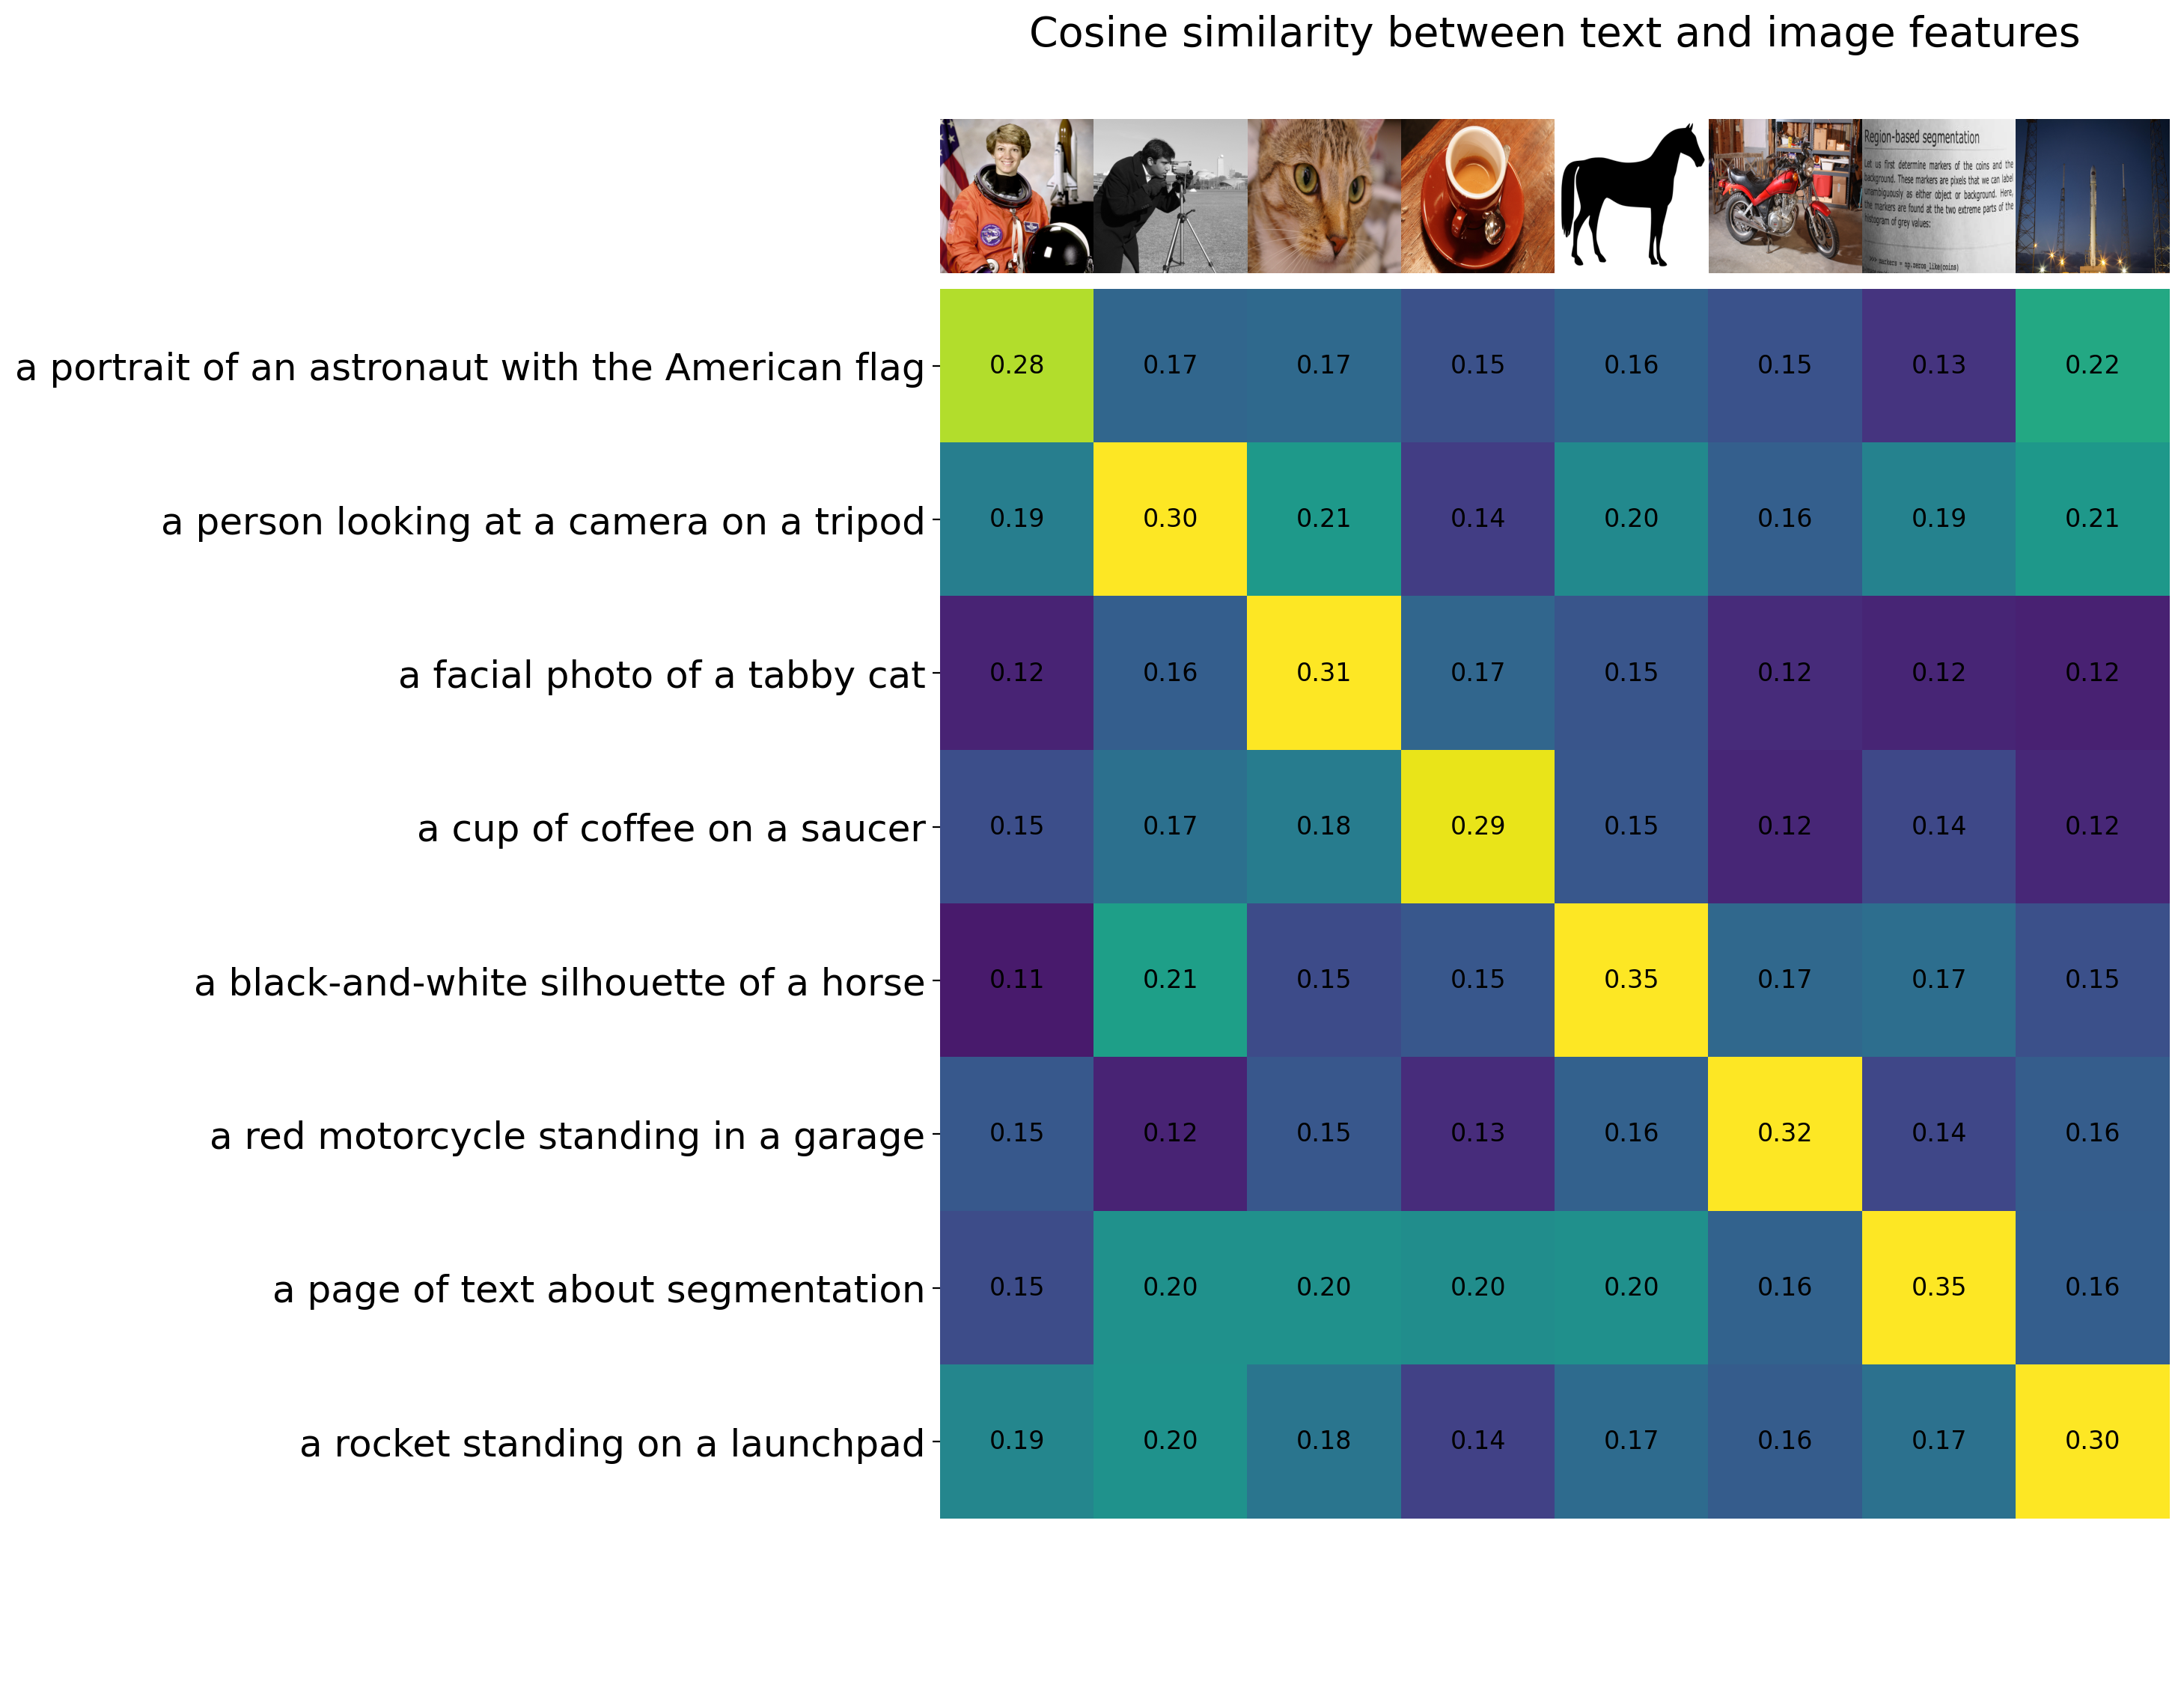

In [55]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

Cosine similarity between one image and one text input.

In [64]:
single_image_feature = image_features[0]  # shape: [D]
single_text_feature = text_features[0]    # shape: [D]

In [65]:
single_image_feature = single_image_feature / single_image_feature.norm()
single_text_feature = single_text_feature / single_text_feature.norm()

In [66]:
cosine_similarity = single_image_feature @ single_text_feature  # This is a scalar
print("Cosine similarity:", cosine_similarity.item())

Cosine similarity: 0.2767535150051117
